In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr
from astropy.convolution import Gaussian2DKernel, convolve

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
ERA5_U.shape

(721, 1440)

In [5]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = earthkit.plots.styles.levels.auto_range(
        da_units,
        divergence_point=divergence_point,
        n_levels=10,
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

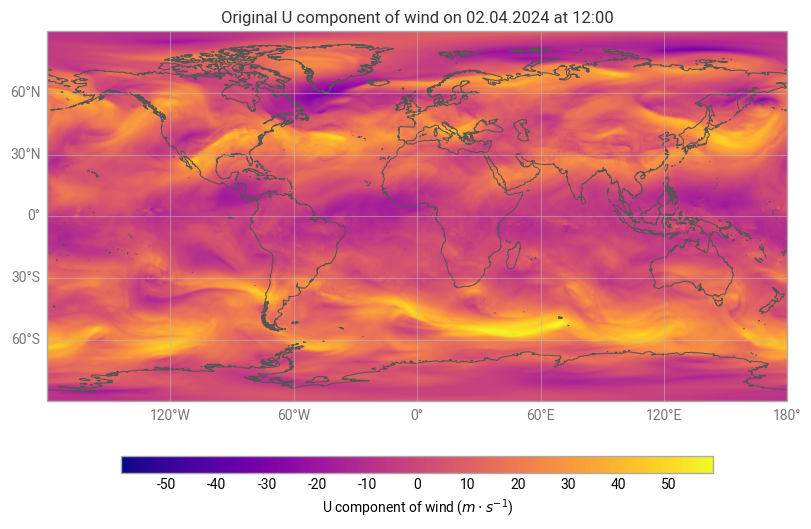

In [6]:
plot_data(ERA5_U, title_prefix="Original ", divergence_point=0)

In [7]:
def dssim(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 11,
) -> float:
    """
    Implementation adapted from the official dSSIM implementation at
    https://github.com/NCAR/ldcpy/blob/6c5bcb8149ec7876a4f53b0e784e9c528f6f14cb/ldcpy/calcs.py#L2516

    The official implementation makes assumptions about the input data that are
    specific to models developed at NCAR which is why we cannot use the official
    implementation directly.

    Parameters
    ----------
    x : np.ndarray
        Shape: (latitude, longitude)
    y : np.ndarray
        Shape: (latitude, longitude)
    kernel_size : int
        The size of the Gaussian kernel for the convolution operation in SSIM. Has to be
        an odd number. The default is 11.

    Returns
    -------
    float
        The data-SSIM value between the two input arrays.
    """
    assert kernel_size % 2 == 1, "kernel_size must be an odd number."

    # re-scale  to [0,1] - if not constant
    smin = min(np.nanmin(a1), np.nanmin(a2))
    smax = max(np.nanmax(a1), np.nanmax(a2))
    r = smax - smin
    if r == 0.0:  # scale by smax if field is a constant (and smax != 0)
        if smax == 0.0:
            sc_a1 = a1
            sc_a2 = a2
        else:
            sc_a1 = a1 / smax
            sc_a2 = a2 / smax
    else:
        sc_a1 = (a1 - smin) / r
        sc_a2 = (a2 - smin) / r

    # now quantize to 256 bins
    sc_a1 = np.round(sc_a1 * 255) / 255
    sc_a2 = np.round(sc_a2 * 255) / 255

    # gaussian filter
    kernel = Gaussian2DKernel(x_stddev=1.5, x_size=kernel_size, y_size=kernel_size)
    filter_args = {"boundary": "fill", "preserve_nan": True}

    a1_mu = convolve(sc_a1, kernel, **filter_args)
    a2_mu = convolve(sc_a2, kernel, **filter_args)

    a1a1 = convolve(sc_a1 * sc_a1, kernel, **filter_args)
    a2a2 = convolve(sc_a2 * sc_a2, kernel, **filter_args)

    a1a2 = convolve(sc_a1 * sc_a2, kernel, **filter_args)

    ###########
    var_a1 = a1a1 - a1_mu * a1_mu
    var_a2 = a2a2 - a2_mu * a2_mu
    cov_a1a2 = a1a2 - a1_mu * a2_mu

    # ssim constants
    C1 = eps
    C2 = eps

    ssim_t1 = 2 * a1_mu * a2_mu + C1
    ssim_t2 = 2 * cov_a1a2 + C2

    ssim_b1 = a1_mu * a1_mu + a2_mu * a2_mu + C1
    ssim_b2 = var_a1 + var_a2 + C2

    ssim_1 = ssim_t1 / ssim_b1
    ssim_2 = ssim_t2 / ssim_b2
    ssim_mat = ssim_1 * ssim_2

    # Cropping the border region of the 2D field where the convolution kernel is not
    # fully overlapping with the 2D input field.
    k = (kernel_size - 1) // 2
    ssim_mat = ssim_mat[k : ssim_mat.shape[0] - k, k : ssim_mat.shape[1] - k]
    return np.nanmean(ssim_mat)

In [8]:
dssim(ERA5_U.values, ERA5_U.values)

np.float32(1.0)

In [9]:
from numcodecs_wasm_zfp import Zfp

In [10]:
zfp = Zfp(mode="fixed-accuracy", tolerance=1)

In [11]:
ERA5_U_zfp = ERA5_U.copy(data=zfp.decode(zfp.encode(ERA5_U.values)))

In [22]:
np.amax(np.abs(ERA5_U - ERA5_U_zfp)).item()

0.5431060791015625

In [12]:
dssim(ERA5_U.values, ERA5_U_zfp.values)

np.float32(0.95741546)

In [13]:
from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings

In [14]:
# re-scale  to [0,1] - if not constant
qoi_smin = np.nanmin(ERA5_U)
qoi_smax = np.nanmax(ERA5_U)
qoi_r = qoi_smax - qoi_smin
qoi_r = np.array(1, dtype=ERA5_U.dtype)[()] if qoi_r == 0 else qoi_r

In [15]:
sg = Safeguards(
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="""
            # now quantize to 256 bins
            let(
                V["sc_a1"],
                round_ties_even((C["data"] - C["smin"][I]) / C["r"][I] * 255) / 255,
            )(let(
                V["sc_a2"],
                round_ties_even((X - C["smin"][I]) / C["r"][I] * 255) / 255,
            )(let(
                V["i"],
                A[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
            )(let(
                V["k"],
                1/(sqrt(2*pi)*C["sigma"][I]) * exp((-V["i"]**2) / (2*C["sigma"][I]**2)),
            )(let(
                V["k_norm"],
                V["k"] / sum(V["k"]),
            )(let(
                V["kernel"],
                matmul(tr(A[V["k_norm"]]), A[V["k_norm"]]),
            )(let(
                V["a1_mu"],
                matmul(V["sc_a1"], V["kernel"])[0,0],
            )(let(
                V["a2_mu"],
                matmul(V["sc_a2"], V["kernel"])[0,0],
            )(let(
                V["a1a1"],
                matmul(V["sc_a1"]**2, V["kernel"])[0,0],
            )(let(
                V["a2a2"],
                matmul(V["sc_a2"]**2, V["kernel"])[0,0],
            )(let(
                V["a1a2"],
                matmul(V["sc_a1"] * V["sc_a2"], V["kernel"])[0,0],
            )(let(
                V["var_a1"],
                V["a1a1"] - V["a1_mu"]**2,
            )(let(
                V["var_a2"],
                V["a2a2"] - V["a2_mu"]**2,
            )(let(
                V["cov_a1a2"],
                V["a1a2"] - V["a1_mu"] * V["a2_mu"],
            )(let(
                V["ssim_t1"],
                2 * V["a1_mu"] * V["a2_mu"] + C["C1"][I],
            )(let(
                V["ssim_t2"],
                2 * V["cov_a1a2"] + C["C2"][I],
            )(let(
                V["ssim_b1"],
                V["a1_mu"]**2 + V["a2_mu"]**2 + C["C1"][I],
            )(let(
                V["ssim_b2"],
                V["var_a1"] + V["var_a2"] + C["C2"][I],
            )(let(
                V["ssim_1"],
                V["ssim_t1"] / V["ssim_b1"],
            )(let(
                V["ssim_2"],
                V["ssim_t2"] / V["ssim_b2"],
            )(
                V["ssim_1"] * V["ssim_2"]
            ))))))))))))))))))))
            """,
            type="abs",
            eb=0.001,
            # 11x11 neighbourhood
            neighbourhood=[
                # latitude
                dict(axis=0, before=5, after=5, boundary="valid"),
                # longitude
                dict(axis=1, before=5, after=5, boundary="valid"),
            ],
        )
    ],
)

In [16]:
print(sg.safeguards[0]._qoi_expr)

((exp(-13/C["sigma"][5, 5]**2)*round_ties_even(255*(C["data"][0, 4] - C["smin"][5, 5])/C["r"][5, 5])/(255*pi*(sqrt(2)/(2*sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-2/C["sigma"][5, 5]**2)/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-8/C["sigma"][5, 5]**2)/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-1/(2*C["sigma"][5, 5]**2))/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-9/(2*C["sigma"][5, 5]**2))/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-25/(2*C["sigma"][5, 5]**2))/(sqrt(pi)*C["sigma"][5, 5]))**2*C["sigma"][5, 5]**2) + exp(-13/C["sigma"][5, 5]**2)*round_ties_even(255*(C["data"][0, 6] - C["smin"][5, 5])/C["r"][5, 5])/(255*pi*(sqrt(2)/(2*sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-2/C["sigma"][5, 5]**2)/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-8/C["sigma"][5, 5]**2)/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-1/(2*C["sigma"][5, 5]**2))/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-9/(2*C["sigma"][5, 5]**2))/(sqrt(pi)*C["sigma"][5, 5]) + sqrt(2)*exp(-25/(2*C["sigma"][5, 5]**2))/(sqrt(pi)*C["sigma"][

In [17]:
prediction = np.zeros_like(ERA5_U.values)

In [18]:
correction_sg = sg.compute_correction(
    ERA5_U.values,
    prediction,
    late_bound=Bindings(
        data=ERA5_U.values,
        smin=qoi_smin,
        r=qoi_r,
        sigma=np.array(1.5, dtype=ERA5_U.dtype)[()],
        C1=np.array(1e-8, dtype=ERA5_U.dtype)[()],
        C2=np.array(1e-8, dtype=ERA5_U.dtype)[()],
    ),
)

ERA5_U_sg = ERA5_U.copy(data=sg.apply_correction(prediction, correction_sg))

In [23]:
np.amax(np.abs(ERA5_U - ERA5_U_sg)).item()

0.1876378059387207

In [19]:
dssim(ERA5_U.values, ERA5_U_sg.values)

np.float32(0.9999534)